# Plot Scratchpad Results

## Prerequisites

In [1]:
import copy
import datetime
import importlib
import re

from pathlib import Path
from typing import List, Dict, Any



import numpy as np
from tqdm.auto import tqdm

import plotnine as p9

import pandas as pd
from collections import deque

from utils import add_src_to_sys_path

add_src_to_sys_path()

from common import wandb_utils, nest
from common import plotnine_utils as p9u
import re

from plotting import attention_analysis_utils as aa_utils

wandb_utils = importlib.reload(wandb_utils)
p9u = importlib.reload(p9u)
# aa_utils = importlib.reload(aa_utils)

wandb_api = wandb_utils.get_wandb_api()

## Load the experiments

In [5]:
tags = ["scratch_for_attn"]

In [3]:
plot_dir_name = "__".join(tags)
output_dir = Path("output_plots") / f"{plot_dir_name}_ind"
output_dir.mkdir(parents=True, exist_ok=True)

In [6]:
df = wandb_utils.download_and_load_results(
    tags=tags,
    # force_download=True,
    force_download=False,
)

df = df[df["job_type"] == "attn_analysis_aggr"]
len(df)

  0%|          | 0/56 [00:00<?, ?it/s]

Building dataframe...
Saving results to /Users/amirhosein/Development/PycharmProjects/len_gen/results/scratch_for_attn.jsonl


13

## Load the data

In [5]:
df["cfg__dataset.name"].unique()

array(['s2s_sum', 's2s_copy', 'pcfg', 's2s_reverse', 'scan'], dtype=object)

In [6]:
df["cfg__dataset.split"].unique()

array(['len_tr8_ts16', 'cmc2x_tr20_ts40', 'rsc2x_tr20_ts40',
       'md_productivity', 'rdc_tr20_ts40', 'cmc_tr20_ts40',
       'mc2x_tr20_ts40', 'mcrv_tr20_ts40', 'mc_tr20_ts40',
       'rsc_tr20_ts40', 'len_tr25_ts48'], dtype=object)

In [5]:
DATASET = "s2s_addition"
SPLIT = "len_tr8_ts16"
TARGET_ATTN_MAP = ["scores", "scores_before"]
# TARGET_ATTN_MAP = ["scores_pass", "scores_rot"]
TARGET_SCRATCHPAD_CONFIG = "i1_c1_o1_v1_r1"

In [20]:
df = df[(df["cfg__dataset.name"] == DATASET) & (df["cfg__dataset.split"] == SPLIT)]
len(df)

36

In [12]:
df["cfg__global_vars.seed"].unique()

array([256788., 234054., 146317.])

In [21]:
scratchpad_config_pattern = re.compile(r"(.)*_scratchpad(.)+_ufs__(i._c._o._v._r.)_.*___.*")

overall_acc_pattern = re.compile(r"pred\/(\w+)_acc_(.+)")
scratchpad_acc_pattern = re.compile(r"pred\/(\w+)__(\w+)_(\w+)")


dataset_cache = {}
tok_info_cache = {}

wandb_api = wandb_utils.get_wandb_api()
analysis_root_dir = Path.home() / "scratch" / "len_gen" / "experiments" / "attention_analysis_data"
aa_utils = importlib.reload(aa_utils)

def find_attention_analysis_runs(group: str):
    runs = wandb_api.runs(
        f"{wandb_utils.get_project_name()}",
        filters={"group": group, "jobType": "attn_analysis2"},
    )
    return list(runs)

def get_ds_and_tok_info(run_row, scratchpad_config):
    ds_name = run_row["cfg__dataset.name"]
    ds_split = run_row["cfg__dataset.split"]
    run_seed = str(int(run_row["cfg__global_vars.seed"]))
    ds_key = (ds_name, ds_split, scratchpad_config, run_seed)
    
    if ds_key not in dataset_cache or ds_key not in tok_info_cache:
        runs = find_attention_analysis_runs(run_row["run_group"])
        assert len(runs) >= 1, "No runs found"
        # Get the run with the same seed
        runs = [r for r in runs if str(int(r.config["global_vars"]["seed"])) == run_seed]
        assert len(runs) == 1, "No runs found"
        dataset, tok_info = aa_utils.download_dataset_for_all_categories(runs[0], analysis_root_dir, scratchpad_config, run_seed)
        dataset_cache[ds_key] = dataset
        tok_info_cache[ds_key] = tok_info
    
    return dataset_cache[ds_key], tok_info_cache[ds_key]


def get_split(key: str) -> str:
    if "test" in key:
        return "test"
    elif "valid" in key:
        return "validation"
    else:
        raise ValueError()


def get_category(key: str) -> int:
    if key == "overall":
        return -1
    if isinstance(key, (int, float)):
        return int(key)
    if "-by-" in key:
        a, b = key.split("-by-")
        a, b = int(a), int(b)
        return max(a, b)
    else:
        return int(key)


output_file_dir = wandb_utils.get_repo_dir() / "results" / "attention_aggr_analysis"
output_file_dir.mkdir(parents=True, exist_ok=True)

xdf_data = deque()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if row["job_type"] != "attn_analysis_aggr":
        continue

    group = row["run_group"]

    scratchpad_config = "no_scratchpad"
    result = scratchpad_config_pattern.search(group)
    if result:
        scratchpad_config = result.group(3)

    if TARGET_SCRATCHPAD_CONFIG is not None and scratchpad_config != TARGET_SCRATCHPAD_CONFIG:
        continue

    seed = row["cfg__global_vars.seed"]
    if int(seed) != 146317:
        print("SKIP", seed)
        continue
    # print(seed)
    # raise ValueError("STOP")

    dataset_name = row["cfg__dataset.name"]
    dataset_split = row["cfg__dataset.split"]
    dataset_pretty = wandb_utils.get_pretty_dataset_name(dataset_name, dataset_split)

    ds, tok_infos = get_ds_and_tok_info(row, scratchpad_config)

    pe_name = wandb_utils.get_pretty_pe_name(row["cfg__model.position_encoding_type"])

    run = wandb_api.run(f"{wandb_utils.get_project_name()}/{row['id']}")
    attention_aggr_files = run.files()

    for aggr_file in attention_aggr_files:
        if not aggr_file.name.endswith(".csv") or not aggr_file.name.startswith("max_attn_idx__"):
            continue

        attention_map_name = aggr_file.name.replace("max_attn_idx__", "").replace(".csv", "")

        if TARGET_ATTN_MAP is not None and attention_map_name not in TARGET_ATTN_MAP:
            print(f"Skipping {attention_map_name}")
            continue

        # Download the attention aggr file
        download_dir = output_file_dir / f"{run.id}"
        download_dir.parent.mkdir(parents=True, exist_ok=True)
        aggr_file_path =  download_dir/ aggr_file.name
        if not aggr_file_path.exists():
            aggr_file.download(replace=True, root=download_dir)

        aggr_df = pd.read_csv(aggr_file_path)
        print(len(aggr_df))

        skipped_number = 0
        for _, aggr_row in aggr_df.iterrows():
            aggr_row = aggr_row.to_dict()
            max_attn_idx = aggr_row["max_attn_idx"].split("-")
            try:
                max_attn_idx = [int(x) for x in max_attn_idx]
            except ValueError:
                print(aggr_row["max_attn_idx"])
                continue
            
            tok_info = tok_infos[str(aggr_row["category"])][aggr_row["sample_idx"]]

            # try:
            #     assert len(max_attn_idx) == len(tok_info["encoding"].tokens()), f"{aggr_row}, {len(max_attn_idx)}, {len(tok_info['encoding'].tokens())}"
            # except AssertionError:
            #     print(f"Skipping {aggr_row['sample_idx']}")
            #     continue

            if len(max_attn_idx) != len(tok_info["encoding"].tokens()):
                skipped_number += 1
                breakpoint()
                continue


            seq_level_region = tok_info["seq_level_region"]
            
            for query_idx, idx in enumerate(max_attn_idx):
                xdf_data.append({
                    "scratchpad_config": scratchpad_config,
                    "ds": dataset_name,
                    "ds_split": dataset_split,
                    "dataset_name": dataset_pretty,
                    "seq_length": get_category(aggr_row["category"]),
                    "pe": pe_name,
                    "attention_map_name": attention_map_name,
                    "query_idx": query_idx,
                    "max_attn_idx": idx,
                    # "head_idx": aggr_row["head_idx"],
                    "layer_idx": aggr_row["layer_idx"],
                    "sample_idx": aggr_row["sample_idx"],
                    "category": aggr_row["category"],
                    "query_region": seq_level_region[query_idx],
                    "max_attn_region": seq_level_region[idx],
                })
        
        print(f"Skipped {skipped_number}/{len(aggr_df)} rows")
            
    print(f"Done with {len(xdf_data)} rows")

oxdf = pd.DataFrame.from_records(xdf_data)
oxdf

  0%|          | 0/36 [00:00<?, ?it/s]

SKIP 256788.0
SKIP 234054.0


Found cached dataset parquet (/home/mila/a/amirhossein.kazemnejad/.cache/huggingface/datasets/parquet/default-06b76d30fef18109/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/mila/a/amirhossein.kazemnejad/.cache/huggingface/datasets/parquet/default-893efa5c9ec953a8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/mila/a/amirhossein.kazemnejad/.cache/huggingface/datasets/parquet/default-50f563f03dd5e7bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/mila/a/amirhossein.kazemnejad/.cache/huggingface/datasets/parquet/default-df9f2fc40b4ffe6b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/mila/a/amirhossein.kazemnejad/.cache/huggingface/datasets/parquet/default-f5f86c9fefa452ed/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found

21600
Skipped 0/21600 rows
Skipping scores_pass
Skipping scores_rot
Done with 3358800 rows
21600
Skipped 0/21600 rows
Done with 6717600 rows
SKIP 234054.0
SKIP 256788.0
21600
Skipped 0/21600 rows
21600
Skipped 0/21600 rows
Done with 13435200 rows
SKIP 234054.0
SKIP 256788.0
SKIP 234054.0
SKIP 256788.0
21600
Skipped 0/21600 rows
21600
Skipped 0/21600 rows
Done with 20152800 rows
21600
Skipped 0/21600 rows
Done with 23511600 rows
SKIP 256788.0
SKIP 234054.0


,scratchpad_config,ds,ds_split,dataset_name,seq_length,pe,attention_map_name,query_idx,max_attn_idx,layer_idx,sample_idx,category,query_region,max_attn_region
0,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),10,Rotary,scores,0,0,0,0,10,input,input
1,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),10,Rotary,scores,1,0,0,0,10,input,input
2,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),10,Rotary,scores,2,1,0,0,10,input,input
3,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),10,Rotary,scores,3,1,0,0,10,input,input
4,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),10,Rotary,scores,4,2,0,0,10,input,input
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23511595,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),9,Absolute Sinusoid,scores,150,13,11,9,9,output,input
23511596,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),9,Absolute Sinusoid,scores,151,135,11,9,9,output,scratchpad
23511597,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),9,Absolute Sinusoid,scores,152,152,11,9,9,output,output
23511598,i0_c1_o1_v0_r0,s2s_sum,len_tr8_ts16,s2s_sum (len_tr8_ts16),9,Absolute Sinusoid,scores,153,146,11,9,9,output,scratchpad


In [22]:
del xdf_data

In [23]:
oxdf["attention_map_name"].unique()

array(['scores', 'scores_before'], dtype=object)

In [24]:
oxdf["pe"].unique()

array(['Rotary', 'No PE', "T5's Relative Bias", 'ALiBi',
       'Absolute Sinusoid'], dtype=object)

## Plot Attention Distances Histogram

In [25]:
xdf = oxdf[oxdf["attention_map_name"] == "scores"]
len(xdf)

16794000

In [26]:
len(xdf)

16794000

### Plot histogram for all layers and heads

1226880


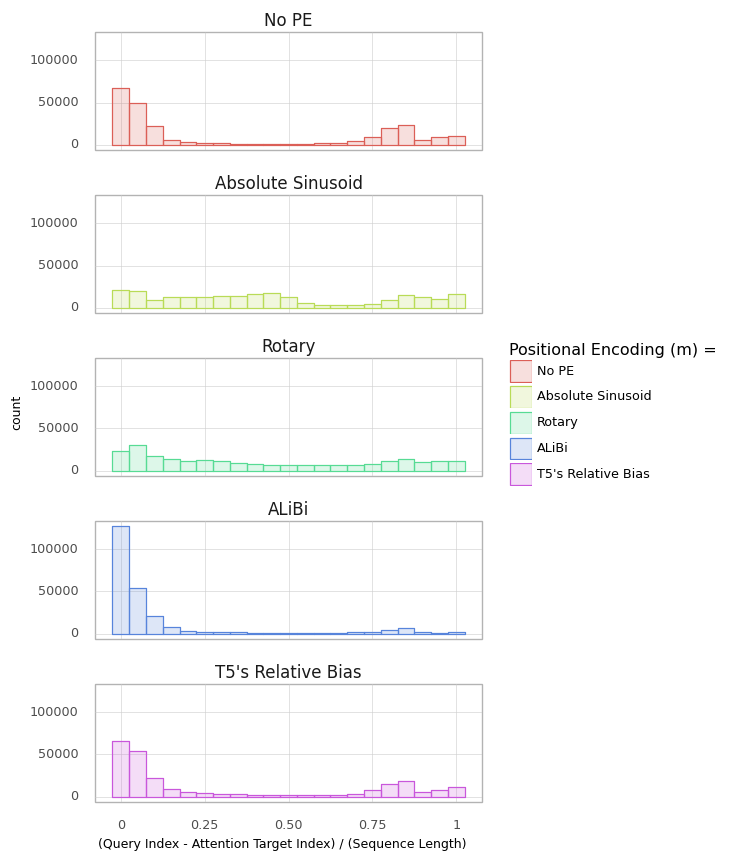

<ggplot: (8786960119034)>

In [24]:
import plotnine as p9

pdf = xdf

assert (pdf["query_idx"] >= pdf["max_attn_idx"]).all()
pdf = pdf[pdf["seq_length"] > 8]
pdf = pdf[pdf["query_region"] == "output"]
pdf = pdf[pdf["seq_length"] % 1 == 0]
# pdf = pdf[pdf["query_idx"] > 0]
pdf["distance_frac"] = (pdf["query_idx"] - pdf["max_attn_idx"]) / (pdf["query_idx"] + 1)
print(len(pdf))


# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="distance_frac", fill="pe", color="pe"))
    # + p9.geom_density(alpha=0.2)
    + p9.geom_histogram(alpha=0.2, binwidth=0.05, position="identity")
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="(Query Index - Attention Target Index) / (Sequence Length)",
        # y="Distance from Query (Normalized over Sequence Length)",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_wrap("pe", ncol=1)
    + p9u.theme_ipsum(grid="XY")
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(5, 10),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

In [28]:
# Sample xdf for 1M samples with seed = 42
xdf2 = xdf.sample(n=1000000, random_state=42)

In [29]:
len(xdf2)

1000000

In [31]:
xdf2.to_csv(wandb_utils.get_repo_dir() / "results" / f"attention_distance_{DATASET}_{SPLIT}_{TARGET_SCRATCHPAD_CONFIG}.csv", index=False)

In [5]:
xdf2 = pd.read_csv(wandb_utils.get_repo_dir() / "results" / f"attention_distance_{DATASET}_{SPLIT}_{TARGET_SCRATCHPAD_CONFIG}.csv")
len(xdf2)

1000000

681345


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 10 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/attention_aggr_analysis_final_ind/attended_distance__s2s_addition__len_tr8_ts16_i1_c1_o1_v1_r1.pdf


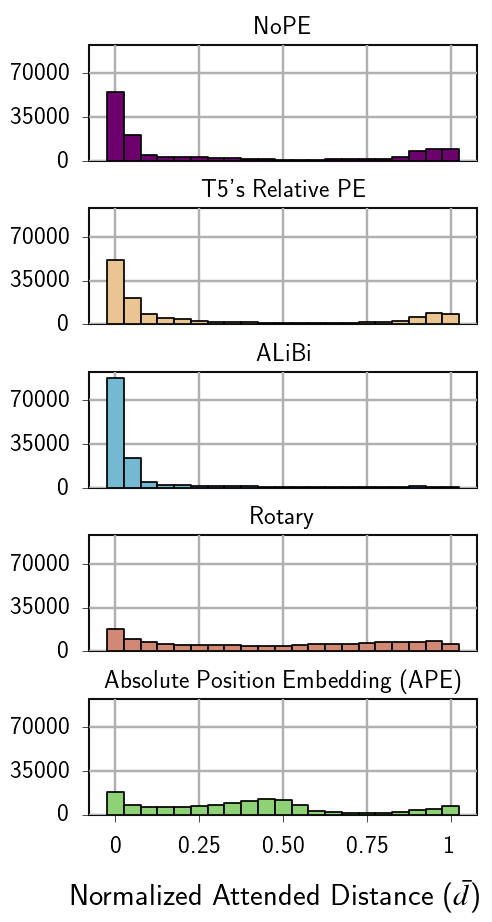

<ggplot: (8786177709846)>

In [20]:
import plotnine as p9

# pdf = xdf2.copy()
pdf = pd.read_csv(
    wandb_utils.get_repo_dir() / "results" / f"attention_distance_pdf_{DATASET}_{SPLIT}_{TARGET_SCRATCHPAD_CONFIG}.csv"
)

assert (pdf["query_idx"] >= pdf["max_attn_idx"]).all()
pdf = pdf[pdf["seq_length"] > 8]
pdf = pdf[pdf["query_region"] == "output"]
pdf = pdf[pdf["seq_length"] % 1 == 0]
# pdf = pdf[pdf["query_idx"] > 0]
pdf["distance_frac"] = (pdf["query_idx"] - pdf["max_attn_idx"]) / (pdf["query_idx"] + 1)
print(len(pdf))


# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding (APE)"
    if "T5" in pe_name:
        return "T5's Relative PE"
    if "No PE" in pe_name:
        return "NoPE"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding (APE)"]
)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="distance_frac", fill="pe", color="pe"))
    + p9.geom_histogram(
        alpha=1, 
        color="black",
        size=0.7,
        binwidth=0.05, 
        position="identity"
    )
#     + p9.geom_density(p9.aes(y=p9.after_stat('count*0.05')), alpha=0.4)
#     + p9.geom_density(
#         alpha=0.5, 
#         color="black",
#         size=0.7,
#         binwidth=0.05, 
#         position="identity"
#     )
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
    + p9.scale_y_continuous(breaks=np.arange(0,90000,35000), limits=(0, 93_000), expand=(0,0))
    + p9.labs(
        x=r"Normalized Attended Distance ($\bar{d}$)",
        y="",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_wrap("pe", ncol=1)
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=22, axis_text_size=18,
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        legend_position="none",
        # legend_box="vertical",
        figure_size=(5, 10),
    )
)
p.save(output_dir / f"attended_distance__{DATASET}__{SPLIT}_{TARGET_SCRATCHPAD_CONFIG}.pdf")
p

24164


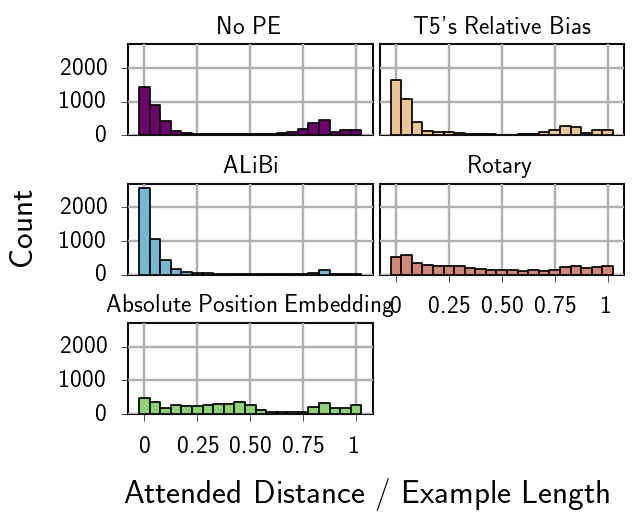

<ggplot: (8766277008794)>

In [29]:
import plotnine as p9

pdf = xdf2.copy()

assert (pdf["query_idx"] >= pdf["max_attn_idx"]).all()
pdf = pdf[pdf["seq_length"] > 8]
pdf = pdf[pdf["query_region"] == "output"]
pdf = pdf[pdf["seq_length"] % 1 == 0]
# pdf = pdf[pdf["query_idx"] > 0]
pdf["distance_frac"] = (pdf["query_idx"] - pdf["max_attn_idx"]) / (pdf["query_idx"] + 1)
print(len(pdf))


# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No PE", "T5's Relative Bias", "ALiBi", "Rotary", "Absolute Position Embedding"]
)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="distance_frac", fill="pe", color="pe"))
    # + p9.geom_density(alpha=0.2)
    + p9.geom_histogram(
        alpha=1, 
        color="black",
        size=0.7,
        binwidth=0.05, 
        position="identity"
    )
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
    + p9.scale_y_continuous(breaks=np.arange(0,3000,1000),limits=[0, 2700], expand=(0,0))
    + p9.labs(
        x="Attended Distance / Example Length",
        y="Count",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_wrap("pe", ncol=2)
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=24, axis_text_size=18,
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        legend_position="none",
        # legend_box="vertical",
#         figure_size=(20, 5),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

1226880


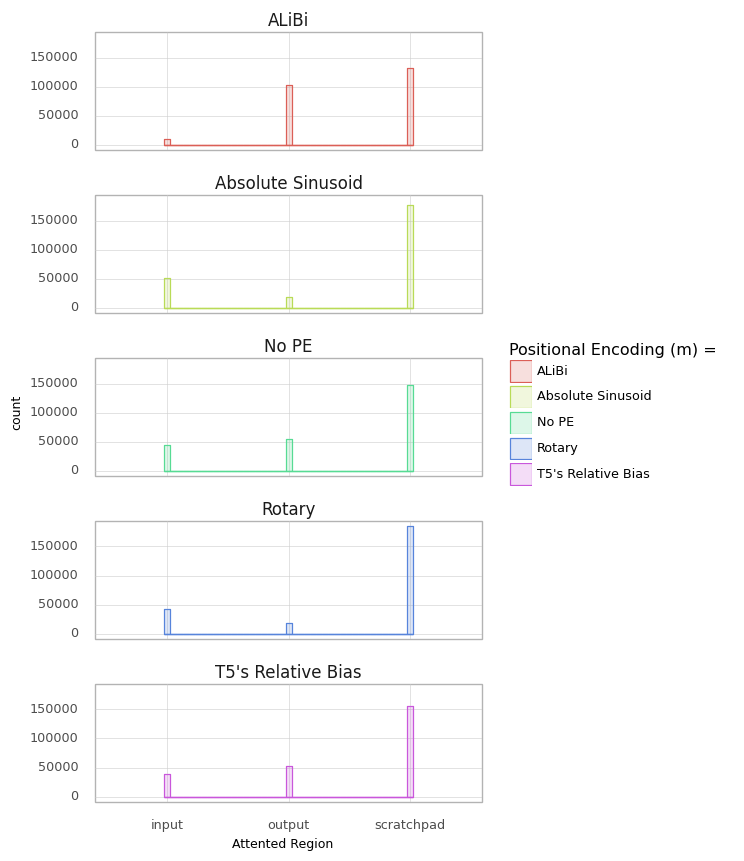

<ggplot: (8786959993893)>

In [25]:
import plotnine as p9

pdf = xdf

assert (pdf["query_idx"] >= pdf["max_attn_idx"]).all()
pdf = pdf[pdf["seq_length"] > 8]
pdf = pdf[pdf["query_region"] == "output"]
pdf = pdf[pdf["seq_length"] % 1 == 0]
# pdf = pdf[pdf["query_idx"] > 0]
pdf["distance_frac"] = (pdf["query_idx"] - pdf["max_attn_idx"]) / (pdf["query_idx"] + 1)
print(len(pdf))


# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
# pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
# pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="max_attn_region", fill="pe", color="pe"))
    # + p9.geom_density(alpha=0.2)
    + p9.geom_histogram(alpha=0.2, binwidth=0.05, position="identity")
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Attented Region",
        # y="Distance from Query (Normalized over Sequence Length)",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_wrap("pe", ncol=1)
    + p9u.theme_ipsum(grid="XY")
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(5, 10),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

## Plot Scores/Distance before/after

In [13]:
oxdf["pe"].unique()

array(['Rotary', 'No PE', "T5's Relative Bias", 'ALiBi',
       'Absolute Sinusoid'], dtype=object)

In [14]:
xdf = oxdf[(oxdf["pe"] == "T5's Relative Bias") | (oxdf["pe"] == "ALiBi")]
len(xdf)

33898176

981504


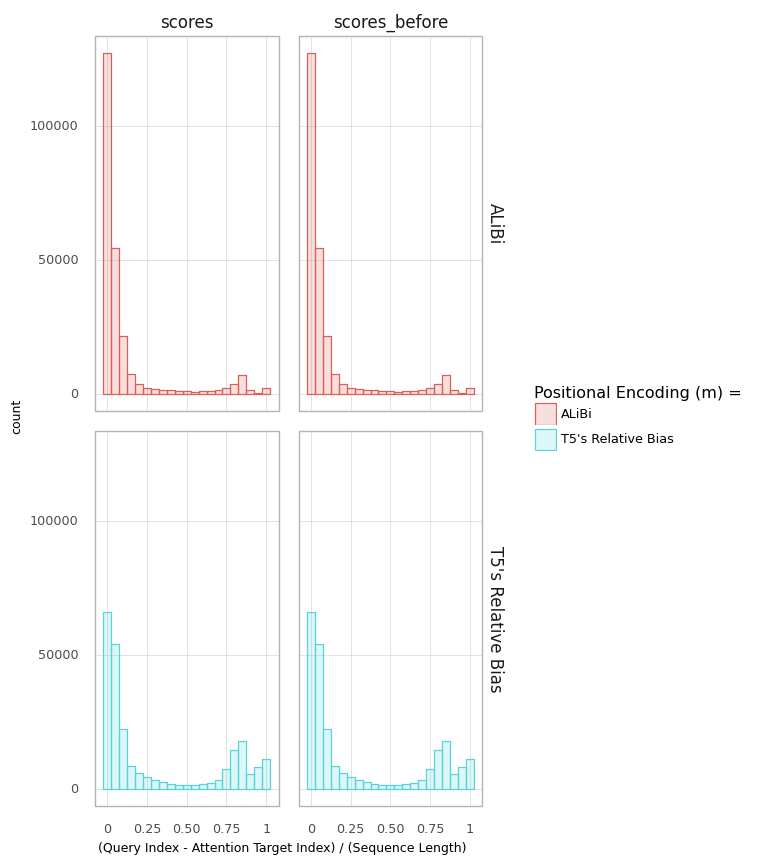

<ggplot: (8731012476103)>

In [15]:
import plotnine as p9

pdf = xdf

assert (pdf["query_idx"] >= pdf["max_attn_idx"]).all()
pdf = pdf[pdf["seq_length"] > 8]
pdf = pdf[pdf["query_region"] == "output"]
pdf = pdf[pdf["seq_length"] % 1 == 0]
# pdf = pdf[pdf["query_idx"] > 0]
pdf["distance_frac"] = (pdf["query_idx"] - pdf["max_attn_idx"]) / (pdf["query_idx"] + 1)
print(len(pdf))


# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="distance_frac", fill="pe", color="pe"))
    # + p9.geom_density(alpha=0.2)
    + p9.geom_histogram(alpha=0.2, binwidth=0.05, position="identity")
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="(Query Index - Attention Target Index) / (Sequence Length)",
        # y="Distance from Query (Normalized over Sequence Length)",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_grid("pe~attention_map_name")
    + p9u.theme_ipsum(grid="XY")
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(5, 10),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

## Plot Rotary content vs Rot. dot product

In [22]:
oxdf["pe"].unique()

array(['Rotary'], dtype=object)

In [23]:
xdf = oxdf[(oxdf["pe"] == "Rotary")]
len(xdf)

16949088

490752


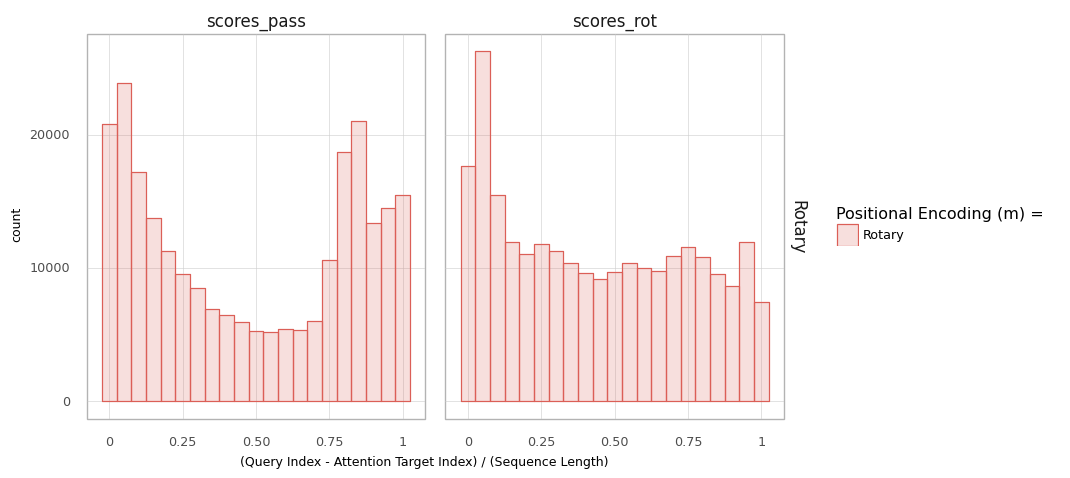

<ggplot: (8731010032890)>

In [25]:
import plotnine as p9

pdf = xdf

assert (pdf["query_idx"] >= pdf["max_attn_idx"]).all()
pdf = pdf[pdf["seq_length"] > 8]
pdf = pdf[pdf["query_region"] == "output"]
pdf = pdf[pdf["seq_length"] % 1 == 0]
# pdf = pdf[pdf["query_idx"] > 0]
pdf["distance_frac"] = (pdf["query_idx"] - pdf["max_attn_idx"]) / (pdf["query_idx"] + 1)
print(len(pdf))


# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="distance_frac", fill="pe", color="pe"))
    # + p9.geom_density(alpha=0.2)
    + p9.geom_histogram(alpha=0.2, binwidth=0.05, position="identity")
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="(Query Index - Attention Target Index) / (Sequence Length)",
        # y="Distance from Query (Normalized over Sequence Length)",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_grid("pe~attention_map_name")
    + p9u.theme_ipsum(grid="XY")
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(9, 5),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

In [ ]:
import plotnine as p9

pdf = xdf

assert (pdf["query_idx"] >= pdf["max_attn_idx"]).all()
pdf = pdf[pdf["seq_length"] > 20]
pdf = pdf[pdf["query_region"] == "output"]
pdf = pdf[pdf["seq_length"] % 2 == 0]
# pdf = pdf[pdf["query_idx"] > 0]
pdf["distance_frac"] = (pdf["query_idx"] - pdf["max_attn_idx"]) / (pdf["query_idx"] + 1)
print(len(pdf))


# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
# pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
# pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="max_", fill="pe", color="pe"))
    # + p9.geom_density(alpha=0.2)
    + p9.geom_histogram(alpha=0.2, binwidth=0.05, position="identity")
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Sequence Length",
        # y="Distance from Query (Normalized over Sequence Length)",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_grid("pe~layer_idx", scales="free")
    + p9u.theme_ipsum(grid="XY")
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(20, 20),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

In [ ]:
pdf.columns

In [ ]:
import plotnine as p9

pdf = xdf


pdf = pdf[pdf["seq_length"] > 25]

# Take max distance
# group_columns = [c for c in pdf.columns if c not in ["distance_frac", "query_idx", "max_attn_idx"]]
# pdf = pdf.groupby(group_columns).agg({"distance_frac": "max"}).reset_index()

# pdf = pdf[(pdf["seq_length"] != -1) & (pdf["distance_frac"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
# pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
# pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)

p = (
    p9.ggplot(pdf, p9.aes(x="distance_frac", fill="pe", color="pe"))
    # + p9.geom_density(alpha=0.2)
    + p9.geom_histogram(alpha=0.2, binwidth=0.05, position="identity")
    # + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    # + p9.annotate("text", x=12, y=5.5, label="I.I.D")
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Sequence Length",
        # y="Distance from Query (Normalized over Sequence Length)",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        # shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
    # + p9.theme_minimal()
    # + p9.theme(
    # + p9.facet_wrap("head_idx", ncol=12)
    + p9.facet_grid("pe~layer_idx", scales="free")
    + p9u.theme_ipsum(grid="XY")
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(20, 20),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

In [ ]:
import plotnine as p9

pdf = xdf
pdf = pdf[(pdf["seq_length"] != -1) & (pdf["kl"].isnull() == False)]
# pdf["scratchpad_config"] = pdf.apply(
#     wandb_utils.df_prettify_scratchpad_config_name, axis=1
# )

# existing_configs = set(pdf["scratchpad_config"].unique().tolist())
# config_order = [
#     pe
#     for pe in wandb_utils.get_pretty_scratchpad_config_order()
#     if pe in existing_configs
# ]
# print(config_order)
# pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
# pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
# pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

# existing_pes = set(pdf["pe"].unique().tolist())
# pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
# pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)


p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y="kl"))
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
        size=1.1,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
    + p9.geom_point(
        mapping=p9.aes(
            fill="pe",
            shape="pe",
        ),
        size=3.0,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        alpha=0.6,
    )
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.2,
        stat="summary",
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=15, alpha=0.1, fill="blue")
    + p9.annotate("text", x=12, y=14, label="I.I.D")
    + p9.facet_wrap("scratchpad_config", ncol=3)
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Sequence Length",
        y="KL < p(NoPE) | p(m) >",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.theme_ipsum(grid="XY", base_family="Times New Roman", axis_title_size=12, axis_text_size=12)
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(8, 4),
    )
)
p.save(output_dir / f"avg_all_layers_all_heads__{DATASET}__{SPLIT}.pdf")
p

### Per layer

In [ ]:
import plotnine as p9

pdf = opdf
pdf = pdf[(pdf["seq_length"] != -1) & (pdf["kl"].isnull() == False)]
pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name, axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [
    pe
    for pe in wandb_utils.get_pretty_scratchpad_config_order()
    if pe in existing_configs
]
print(config_order)
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)

p9u = importlib.reload(p9u)


p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y="kl"))
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
        size=1.1,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
#     + p9.geom_point(
#         mapping=p9.aes(
#             fill="pe",
#             shape="pe",
#         ),
#         size=3.0,
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         alpha=0.6,
#     )
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.2,
        stat="summary",
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.1, fill="blue")
    + p9.annotate("text", x=12, y=5.5, label="I.I.D")
    + p9.facet_wrap("layer_idx", ncol=3)
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Sequence Length",
        y="KL < p(NoPE) | p(m) >",
        color="Positional Encoding (m) =",
        fill="Positional Encoding (m) =",
        shape="Positional Encoding (m) =",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.theme_ipsum(grid="XY", base_family="Times New Roman", axis_title_size=12, axis_text_size=12)
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(13, 8),
    )
)
p.save(output_dir / f"per_layer__{DATASET}__{SPLIT}.pdf")
p